In [1]:
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
import matplotlib.pyplot as plt
from GeneralModel import *

In [5]:
def Flow(t, x, params):
    I = params["I"]
    a, b, tau = -0.7, 0.8, 1/0.08
    V, w = x[0], x[1]
    
    dV = V - V**3 - w + I
    dw = V - a - b*w
    
    return np.array([dV, dw])

{'I': 1}


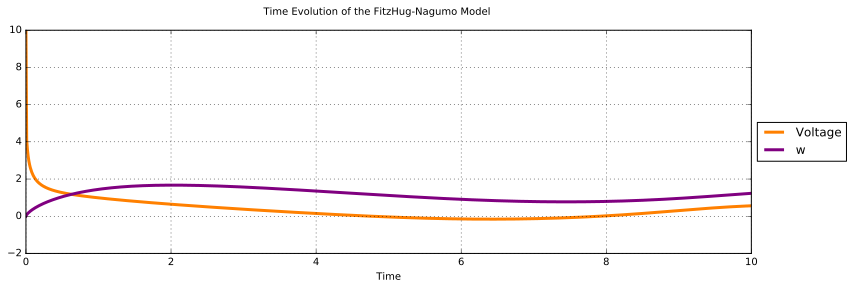

In [15]:
FH = GeneralModel(Name="FitzHug-Nagumo", tstart=0, tend=10, dt=0.01, I=1)
FH.Initialize([10,0])
FH.Simulate(Flow=Flow)
plt.rcParams["figure.figsize"] = (13, 4)
FH.PlotState(states={1:"V",2:"w"},legend=["Voltage","w"])

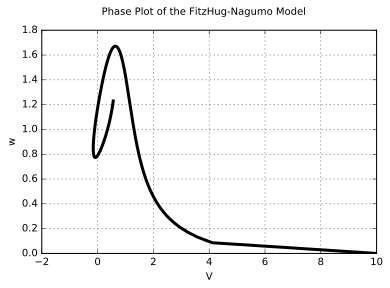

In [17]:
plt.rcParams["figure.figsize"] = (6, 4)
FH.PlotPhase(states={1:"V",2:"w"})